In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
sys.path.append("/Users/chernals/cernbox/Work/packages")
sys.path.append("/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines")
PATH = "/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import georges
import physics
from magnets import esbtsquad_current_to_gradient

In [2]:
r = 25
energy = georges.physics.range_to_energy(r)
pc = georges.physics.energy_to_momentum(energy)
brho = georges.physics.momentum_to_brho(pc)
context = {
        'PARTICLE': 'PROTON',
        'PC': pc,
        'BETAX'   : physics.get_degrader_spot_size(energy)/physics.get_degrader_divergence(energy),
        'BETAY'   : physics.get_degrader_spot_size(energy)/physics.get_degrader_divergence(energy),
        'ALPHAX': 0.0,
        'ALPHAY': 0.0,
        'DELTAP': 0.0,
        'DPP': 0.2e-2,
        'MOMENTUM_SLITS_OPENING' : 1.015,
        'DIVERGENCE_SLITS_OPENING_X' : 1.015,
        'DIVERGENCE_SLITS_OPENING_Y' : 1.015,
        'N_TRACKING': 5000,
        'EMITX': 1e-6*physics.get_degrader_spot_size(energy)*physics.get_degrader_divergence(energy),
        'EMITY': 1e-6*physics.get_degrader_spot_size(energy)*physics.get_degrader_divergence(energy),
        'IQ1E': esbtsquad_current_to_gradient(61.3648)/brho,
        'IQ2E': -esbtsquad_current_to_gradient(125.0646)/brho,
        'IQ3E': esbtsquad_current_to_gradient(87.29035)/brho,
        'IQ47E': -esbtsquad_current_to_gradient(65.06655)/brho,
        'IQ56E': esbtsquad_current_to_gradient(56.10315)/brho,
        'IQ8E': esbtsquad_current_to_gradient(63.98455)/brho,
        'IQ9E': -esbtsquad_current_to_gradient(62.71815)/brho,
        'IQ10E': esbtsquad_current_to_gradient(21.15985)/brho,
        'IQ1B1': esbtsquad_current_to_gradient(107.67265)/brho,
        'IQ2B1': -esbtsquad_current_to_gradient(109.94395)/brho,
        'IQ3B1': esbtsquad_current_to_gradient(107.67265)/brho,
        'IQ1F1': -esbtsquad_current_to_gradient(41.27555)/brho,
        'IQ2F1': esbtsquad_current_to_gradient(36.8144)/brho,
}

In [3]:
bl = georges.Beamline(['fstr1'], survey=True, path=PATH, prefix='PAT107', elements='elements')
#bl.line = bl.line.append(pd.Series({'PHYSICAL': True, 'AT_ENTRY': 1.75, 'AT_CENTER': 1.75, 'AT_EXIT': 1.75, 'TYPE': 'COLLIMATOR', 'CLASS': 'COLLIMATOR', 'APERTYPE': 'RECTANGLE', 'APERTURE': '[0.006, 0.002]'}).rename("DIV")).sort_values(by='AT_CENTER')
#bl.line = bl.line.append(pd.Series({'PHYSICAL': True, 'AT_ENTRY': 5.5, 'AT_CENTER': 5.5, 'AT_EXIT': 5.5, 'TYPE': 'COLLIMATOR', 'CLASS': 'COLLIMATOR', 'APERTYPE': 'RECTANGLE', 'APERTURE': '[0.0125, 0.1]'}).rename("MOM")).sort_values(by='AT_CENTER')
bl.to_thin('Q2E', context['IQ3E']*0.295)

bl_survey = georges.madx.survey(line=bl, context=context)
bl_twiss = georges.madx.twiss(line=bl, context=context, ptc=False, debug=False)
b = georges.Beam(energy=200).from_5d_multigaussian_distribution(context['N_TRACKING'],
                                                   XRMS=physics.get_degrader_spot_size(energy)/1000/4,
                                                   PXRMS=physics.get_degrader_divergence(energy)/1000/4,
                                                   YRMS=physics.get_degrader_spot_size(energy)/1000,
                                                   PYRMS=physics.get_degrader_divergence(energy)/1000/2,
                                                   DPPRMS=0.00)
bl_track = georges.madx.track(line=bl.add_markers(), context=context, beam=b, debug=False)

In [34]:
bl_track.line.loc['Q2E_IN']['BEAM'].emit

{'X': 1.04894110458706e-06, 'Y': 9.2537572980141685e-06}

In [33]:
print("<X2> variquad: {}".format(1000*np.sqrt(variquad['s11'])))
print("<X2> tracking: {}".format(1000*bl_track.line.query("BEAM == BEAM")['BEAM'].apply(lambda r: r.std['X'])['Q2E_IN']))
print("<PX2> variquad: {}".format(1000*np.sqrt(variquad['s22'])))
print("<PX2> tracking: {}".format(1000*bl_track.line.query("BEAM == BEAM")['BEAM'].apply(lambda r: r.std['PX'])['Q2E_IN']))

<X2> variquad: 3.0605870000292312
<X2> tracking: 3.0659941026201207
<PX2> variquad: 1.392105072545897
<PX2> tracking: 1.9592133726858119


{'alpha': -3.5085630305455267,
 'beta': 8.0208792481729176,
 'emit': 1.167851116432365e-06,
 'fit': [array([  2.90800405e-07,  -1.95687571e-07,   8.48614908e-08]),
  array([  6.24838781e-10,   1.40509429e-09,   5.42761124e-09])],
 'fit_function': <function georges.measure.variquad.variquad.<locals>.<lambda>>,
 'gamma': 1.6594208848540775,
 'map': <georges.beamline.Beamline at 0x10bf1c6d8>,
 's11': 9.36719278474793e-06,
 's12': 4.0974792522959151e-06,
 's22': 1.9379565330080173e-06,
 'x': array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 'y': array([  5.51137748e-06,   3.52455894e-06,   1.96294037e-06,
          8.50524517e-07,   2.19136787e-07,   5.16505190e-08,
          3.45552798e-07,   1.09963158e-06,   2.28983506e-06,
          3.94928511e-06])}

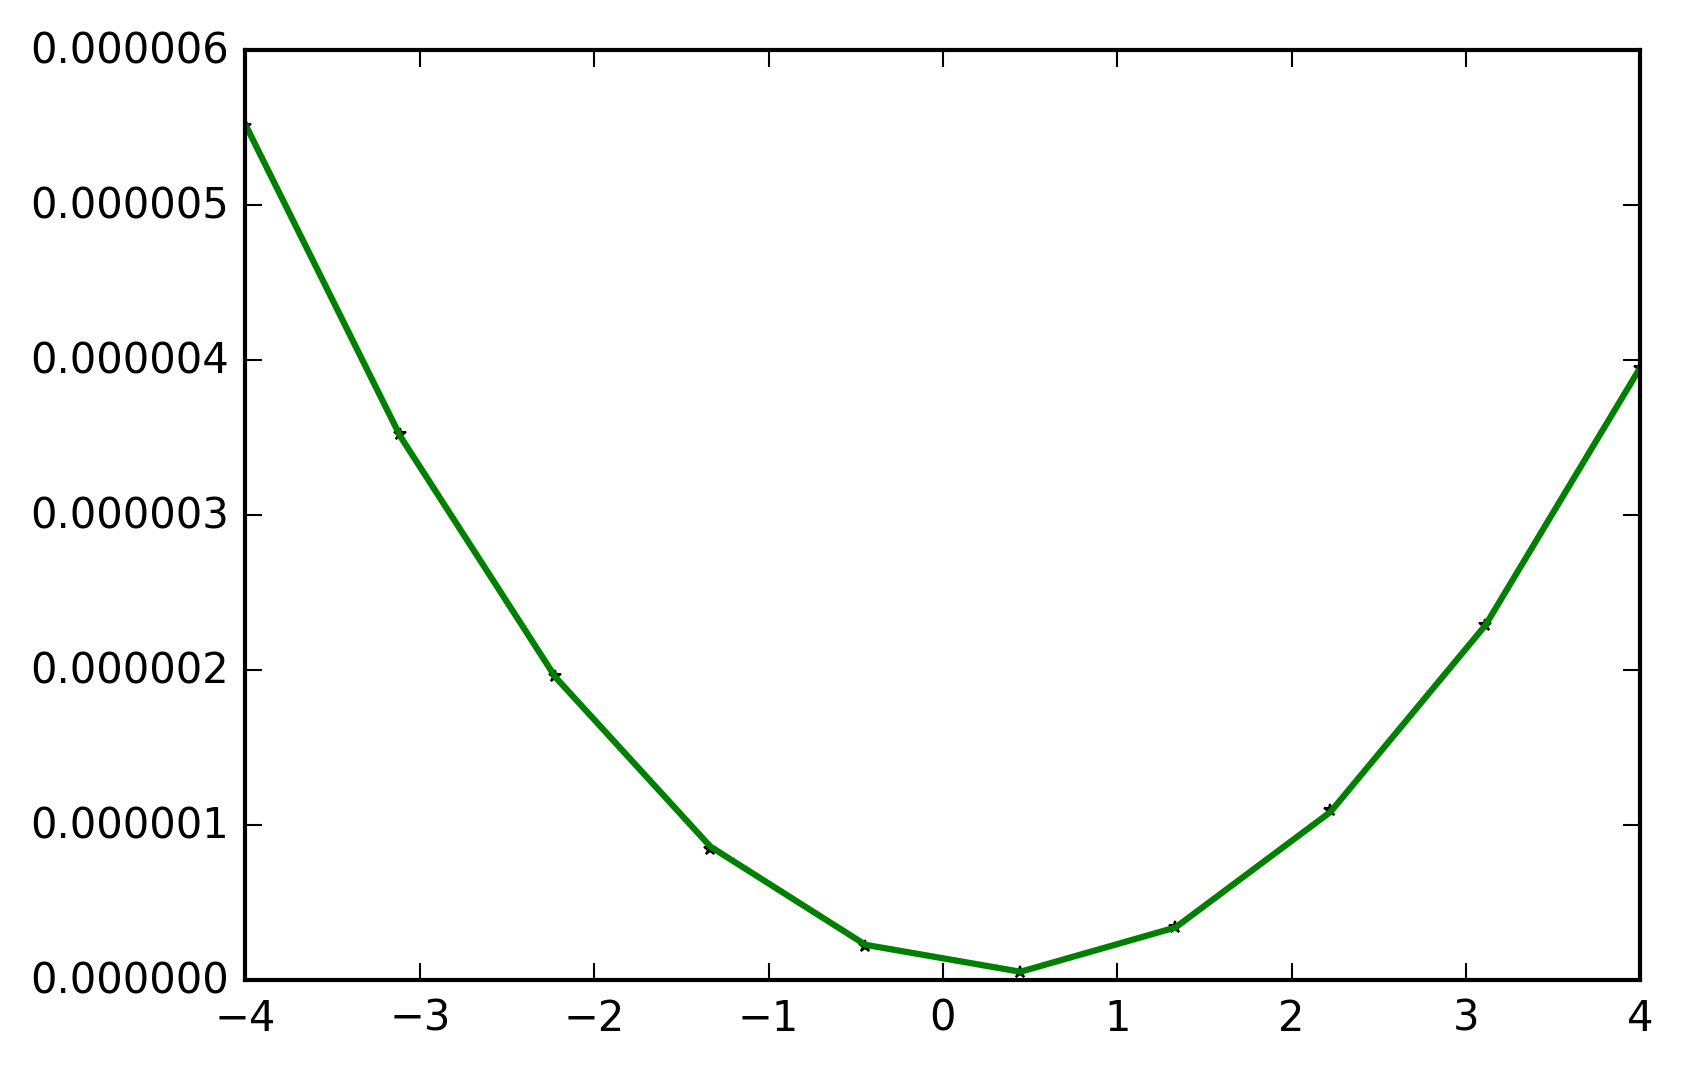

In [32]:
variquad = georges.measure.variquad(data=variquad_data, 
                         line=bl, 
                         context=context, 
                         start='Q2E', 
                         end='P2E', 
                         quad_length=0.295, 
                         plane='X',
                         debug=False
                        )
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(variquad['x'], variquad['y'], '*')
ax.plot(variquad['x'], variquad['fit_function'](variquad['x']))
variquad#['map'].line[['R11','R12','R22','R33','R34','R44']]

array([[ -4.00000000e+00,   2.34763231e-03],
       [ -3.11111111e+00,   1.87738087e-03],
       [ -2.22222222e+00,   1.40104974e-03],
       [ -1.33333333e+00,   9.22238861e-04],
       [ -4.44444444e-01,   4.68120484e-04],
       [  4.44444444e-01,   2.27267505e-04],
       [  1.33333333e+00,   5.87837391e-04],
       [  2.22222222e+00,   1.04863320e-03],
       [  3.11111111e+00,   1.51322010e-03],
       [  4.00000000e+00,   1.98728083e-03]])

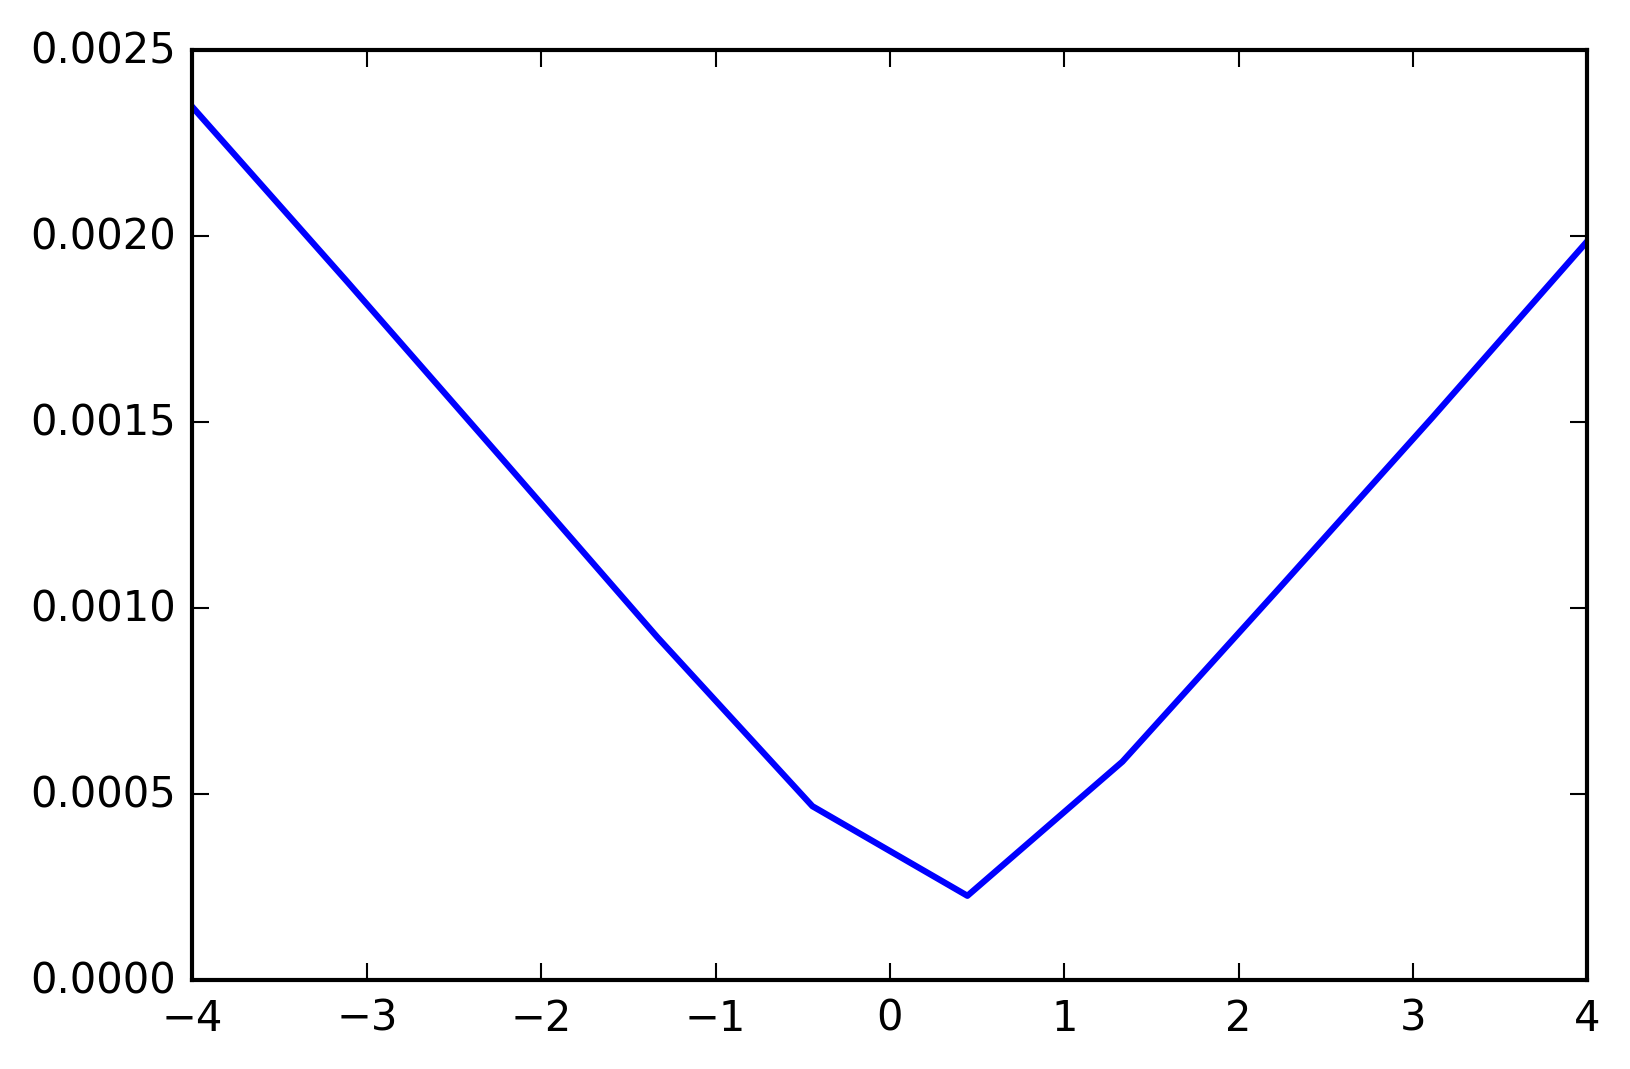

In [31]:
variquad_data = []
for c in np.linspace(0.295*(-4), 0.295*(4), 10):
    bl = georges.Beamline(['fstr1'], survey=True, path=PATH, prefix='PAT107', elements='elements')
    bl.to_thin('Q2E', c)
    bl_track = georges.madx.track(line=bl.add_markers(), context=context, beam=b, debug=False)
    variquad_data.append([c/0.295, bl_track.line.query("BEAM == BEAM")['BEAM'].apply(lambda r: r.std['X'])['P2E']])
    
variquad_data = np.array(variquad_data)
plt.plot(variquad_data[:,0],variquad_data[:,1])
variquad_data

In [57]:
bdsim = georges.bdsim.BDSim(bdsim='/Users/chernals/bdsim-build/bdsim', path=PATH)
bdsim.attach(bl_survey)
bdsim.run({})
#bdsim.print_input()

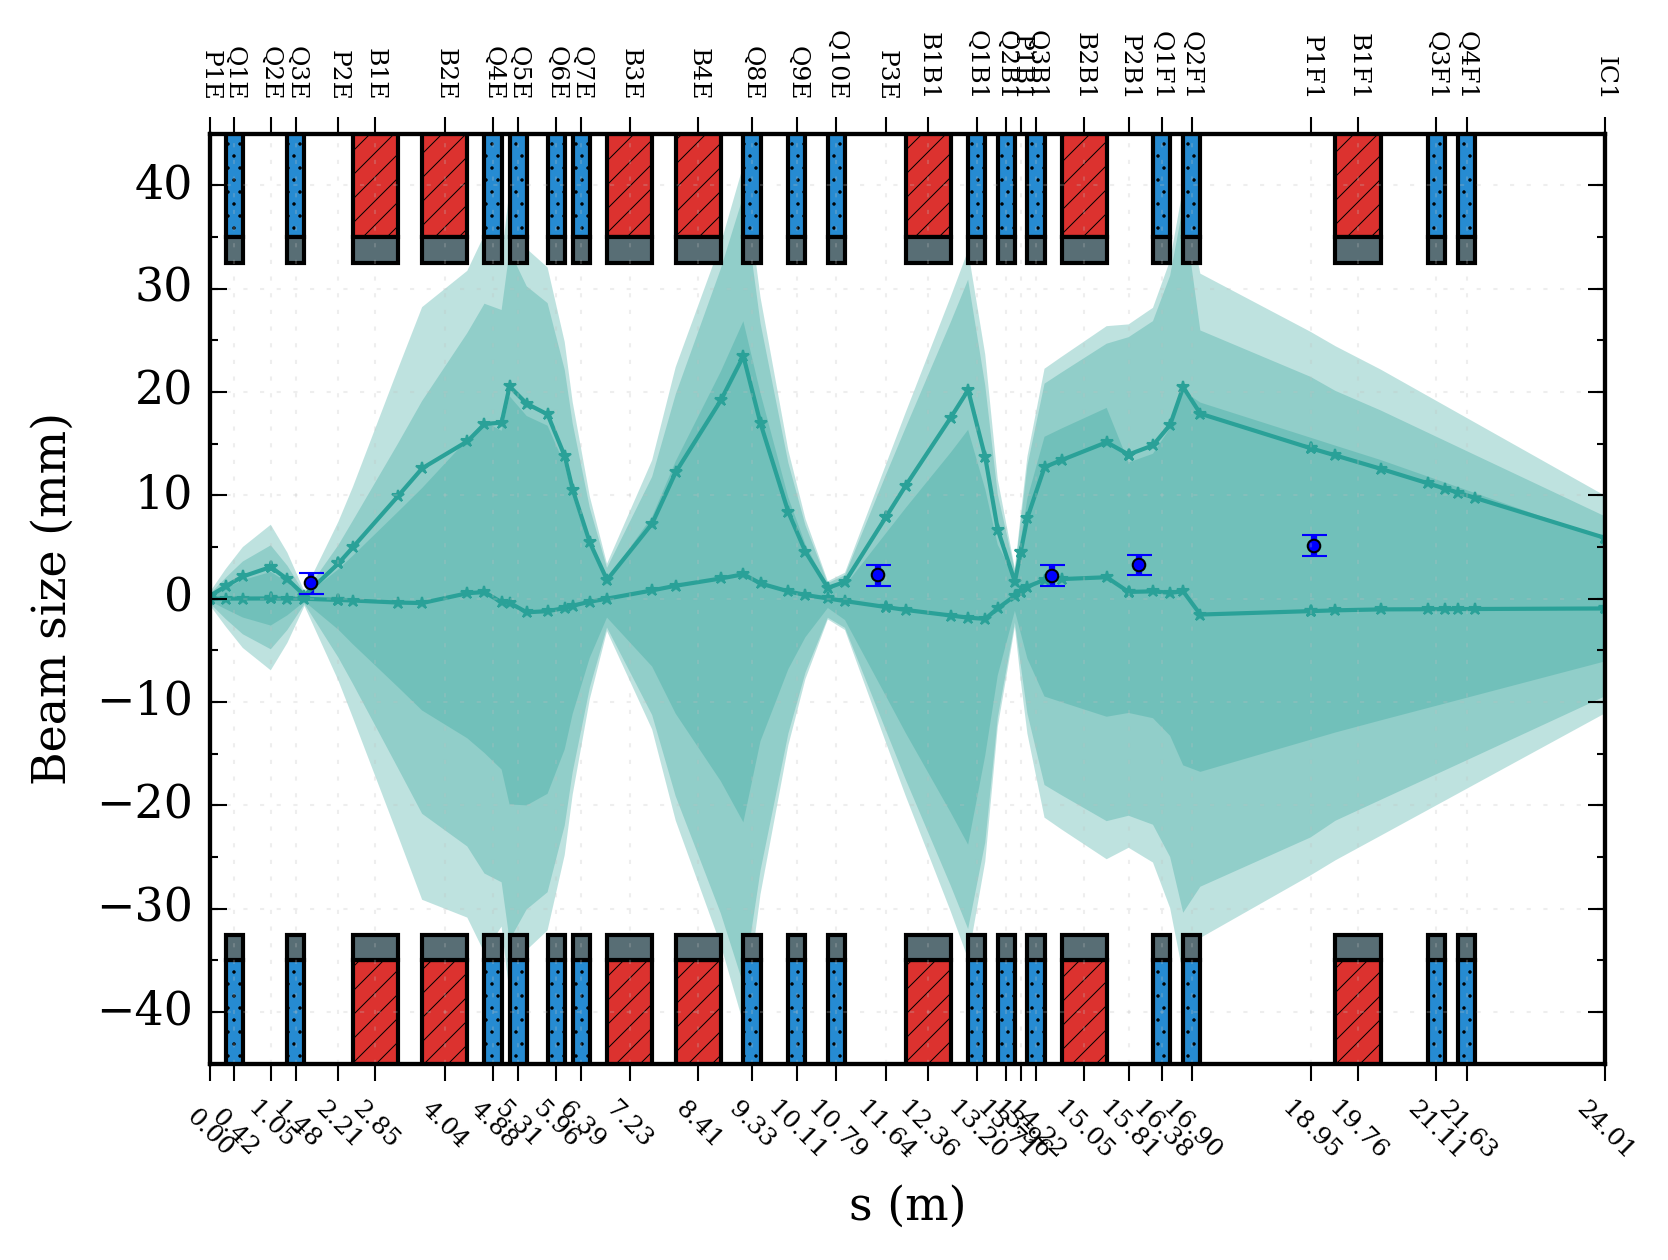

In [7]:
from georges.plotting import *
with plt.style.context('word'):
    fig = plt.figure(1)

    ax1 = fig.add_subplot(111)
    prepare(ax1, bl)
    aperture(ax1, bl)
    #twiss(ax1, bl_twiss, context)
    tracking(ax1, bl_track, context, plane='X')
    

    x = [1.75,11.5, 14.5, 16, 19]
    y= [1.50,2.273, 2.2431, 3.27796, 5.13184091]
    err = [1, 1, 1, 1, 1]
    ax1.errorbar(x, y, yerr=err, fmt='o')

NameError: name 'bl_track' is not defined

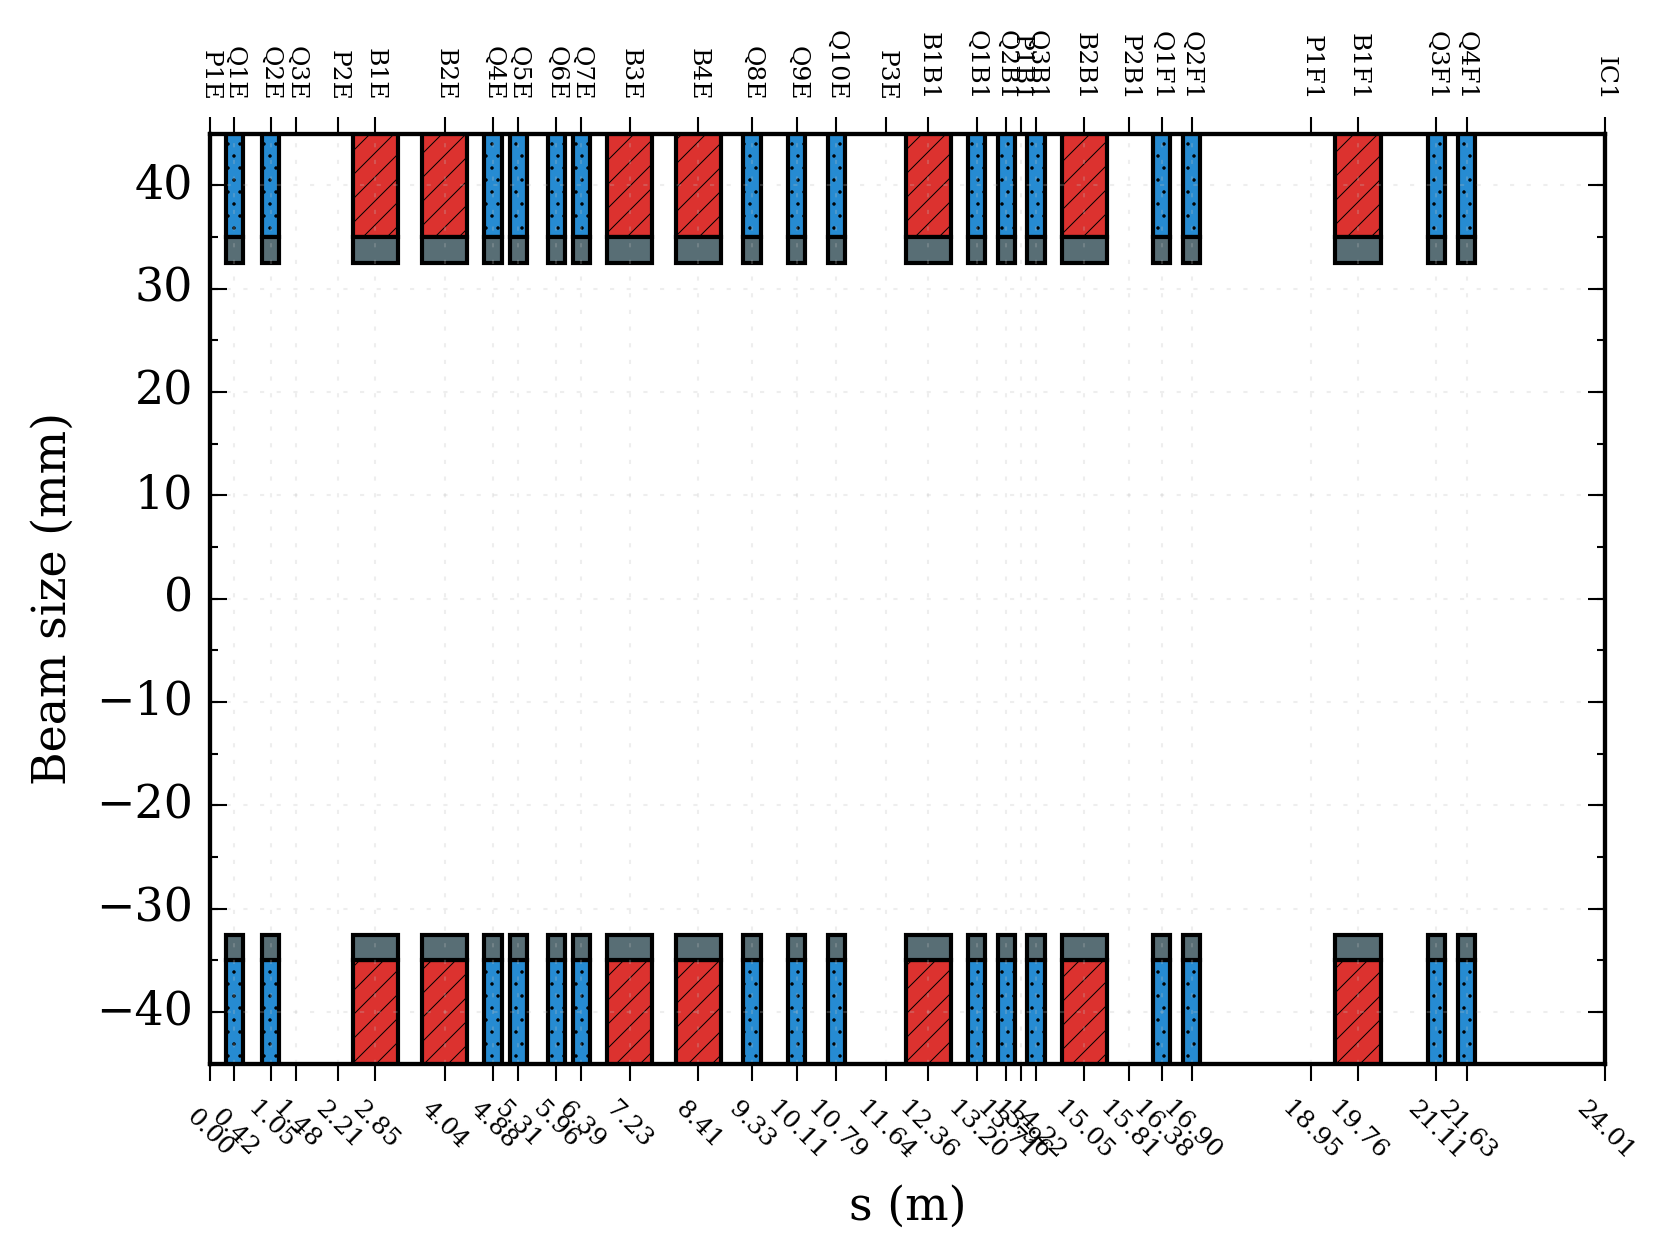

In [19]:
from georges.plotting import *
with plt.style.context('word'):
    fig = plt.figure(1)

    ax1 = fig.add_subplot(111)
    prepare(ax1, bl)
    aperture(ax1, bl)
    #twiss(ax1, bl_twiss, context)
    tracking(ax1, bl_track, context, plane='Y')
    
    #ax1.set_ylim([0, 10])
    x = [1.7,11.5, 14.5, 16, 19]
    y= [4.667,2.800, 1.54, 6.36, 4.16]
    err = [1, 1, 1, 1, 1]
    #ax1.errorbar(x, y, yerr=err, fmt='o')

In [37]:
import numpy as np
data = pd.read_csv("/Users/chernals/Ranges.csv", index_col='range')
ranges = pd.Series(pd.to_numeric(data.columns))
data.index
#ranges = data.columns.is_monotonic_decreasing
#ranges

Index(['DEGRADER', 'GROUP3', 'Q1E', 'Q2E', 'Q3E', 'Q47E', 'Q56E', 'Q8E', 'Q9E',
       'Q10E', 'Q1B1', 'Q2B1', 'Q3B1', 'Q1F1', 'Q2F1', 'B1234E', 'B12B1',
       'TRB34E', 'T2E', 'TRB2B1', 'T1F1', 'B1F1', 'Q3F1', 'Q4F1', 'SL1E',
       'SL2E', 'SL3E'],
      dtype='object', name='range')

'D'

In [150]:
data.query("index=='GROUP3'").interpolate()#.values

,32.54,31.5,30.5,29.5,28.5,27.5,26.5,25.5,24.5,23.5,...,15.5,14.5,13.5,12.5,11.5,10.5,9.5,8.5,7.72,4.1
range,,,,,,,,,,,,,,,,,,,,,
GROUP3,1.58967,1.57222,1.55514,1.53777,1.52007,1.50204,1.48364,1.46486,1.44566,1.42602,...,1.24788,1.22206,1.19514,1.16697,1.13737,1.10613,1.07297,1.03751,1.00795,0.837952


In [152]:
import subprocess as sub
p = sub.Popen(["/Users/chernals/bdsim-build/bdsim --file=/Users/chernals/Desktop/bdsim.gmad"],
                      
                      shell=True
                      )

In [154]:
from subprocess import call
call(["/Users/chernals/bdsim-build/bdsim", "--file=/Users/chernals/Desktop/bdsim.gmad"])

1

In [185]:
from georges.plotting import *

survey(ax)

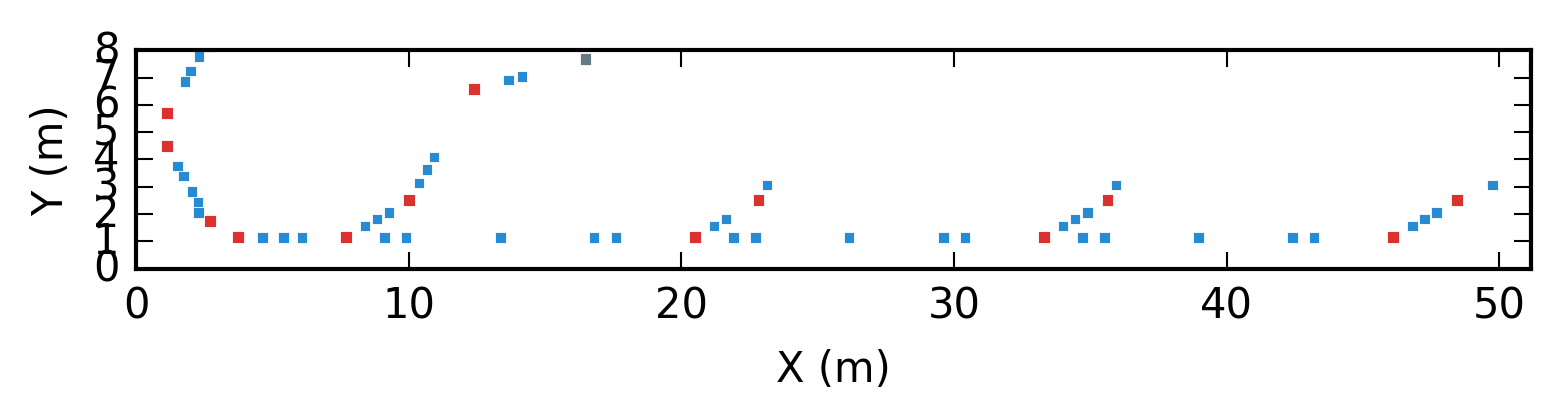

In [203]:
import matplotlib.patches as patches

bl = georges.Beamline(['essen'], survey=True, path=PATH, prefix='generic', elements='elements')


fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_xlim([0, np.max(bl.line['X']) / 1000])
ax1.set_ylim([0, np.max(bl.line['Y']) / 1000])
for index, row in bl.line.iterrows():
    if pd.notnull(row['X']) and pd.notnull(row['Y']):
        #ax1.annotate(index, xy=(row['X'] / 1000, row['Y'] / 1000), xytext=(row['X'] / 1000+0.5, row['Y'] / 1000 + 0.5),
        #    arrowprops=dict(arrowstyle="->",
        #                    facecolor='black', 
        #                    shrinkA = 50,
        #                    shrinkB = 5000,
        #                   ),
        #    size = 3,
        #    horizontalalignment='left',
        #    verticalalignment='bottom',
        #    clip_on=True
        #)
        if row['CLASS'] == 'QUADRUPOLE':
            ax1.add_patch(
                patches.Rectangle(
                    (row['X'] / 1000, row['Y'] / 1000),   # (x,y)
                    0.20,          # width
                    0.20,          # height
                    facecolor = '#268bd2',
                    edgecolor = '#268bd2'
                )
            )
        elif row['CLASS'] == 'RBEND' or row['CLASS'] == 'SBEND':
            ax1.add_patch(
                patches.Rectangle(
                    (row['X'] / 1000, row['Y'] / 1000),   # (x,y)
                    0.250,          # width
                    0.250,          # height
                    facecolor = '#dc322f',
                    edgecolor = '#dc322f'
                )
            )
        else:
            ax1.add_patch(
                patches.Rectangle(
                    (row['X'] / 1000, row['Y'] / 1000),   # (x,y)
                    0.250,          # width
                    0.250,          # height
                    facecolor = '#657b83',
                    edgecolor = '#657b83'
                )
            )

In [194]:
fig1.savefig('myfig.svg')


NameError: name 'bl' is not defined

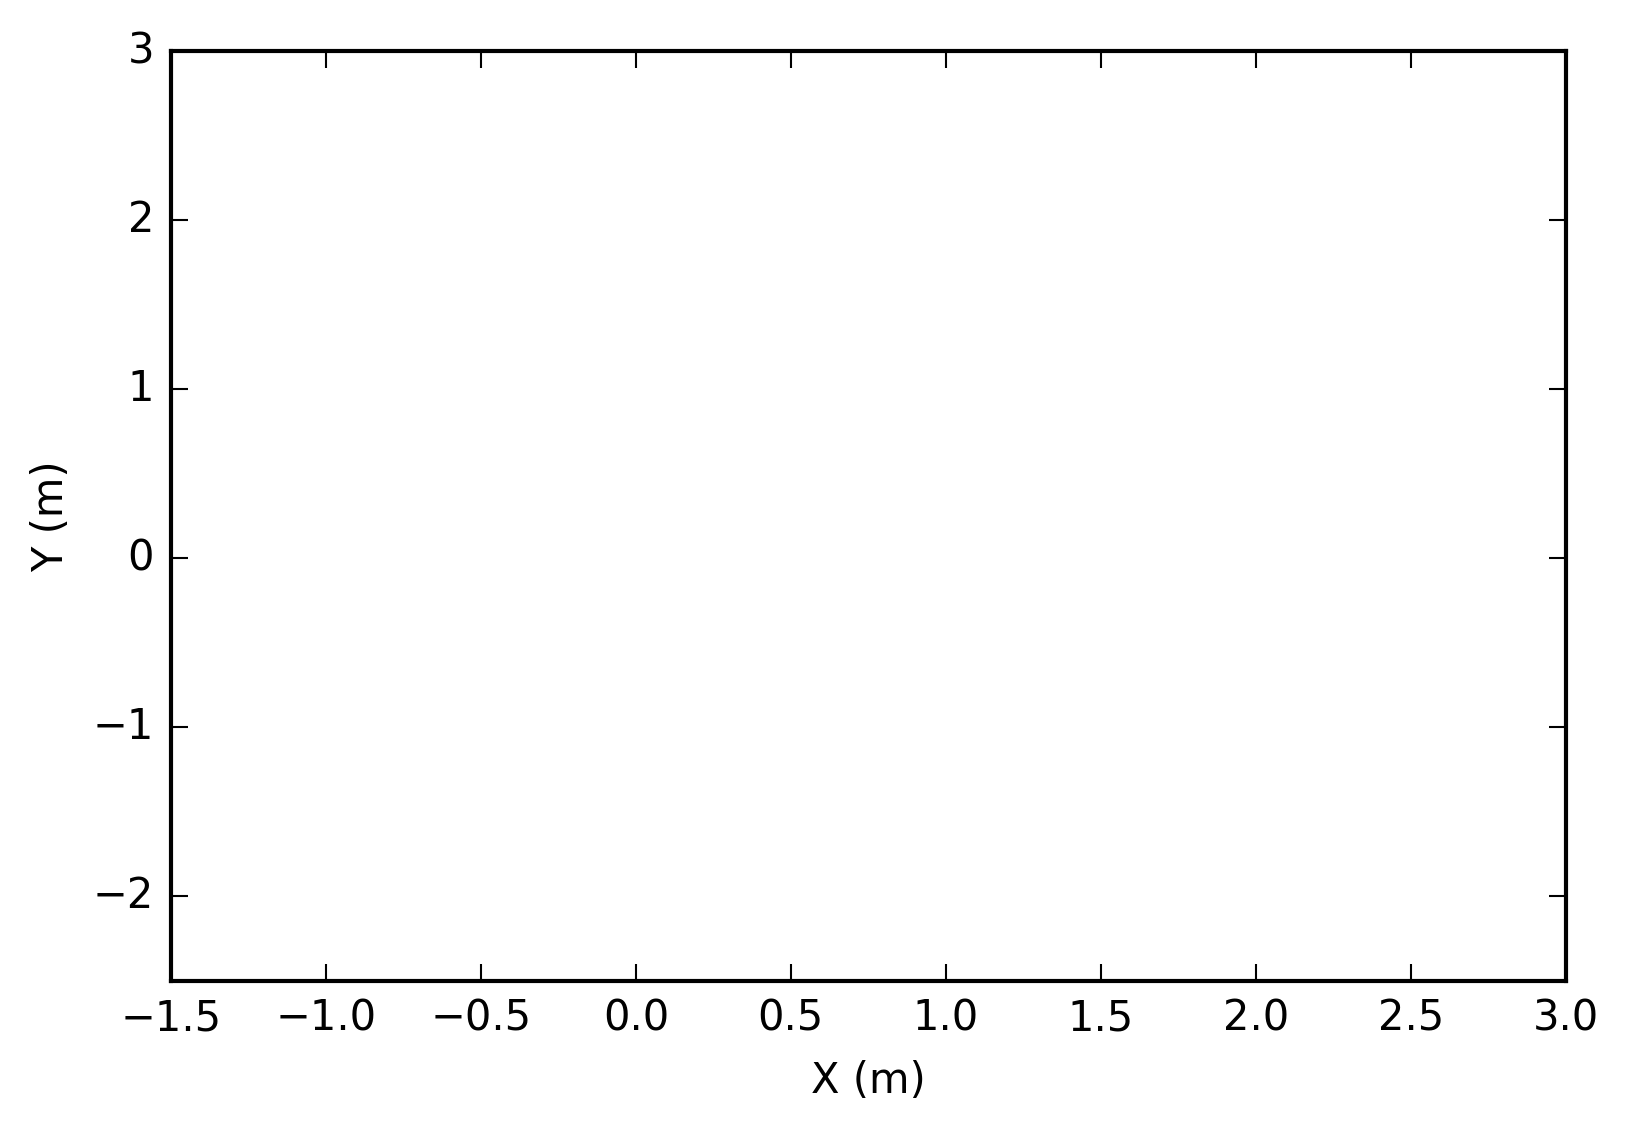

In [17]:
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.path import Path
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)#, aspect='equal')
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_xlim([-1.5, 3])
ax1.set_ylim([-2.5, 3])

tmp = 90
ax1.plot(bl.line['Z'], bl.line['X'], '*')
for index, row in bl.line.iterrows():
    if row['KEYWORD'] == 'SBEND':
        r = row['L']/row['ANGLE']
        theta = -row['THETA']
        angle = row['ANGLE']/np.pi*180.0
        centre = [row['Z']-np.sin(theta)*r,row['X']-np.cos(theta)*r]
        theta1 = min(tmp, tmp-angle)
        theta2 = max(tmp, tmp-angle)
        if angle > 0:
            tmp = theta1
        else:
            tmp = theta2
        w = patches.Wedge(centre, r+0.1, theta1, theta2, width=0.2, facecolor='red', ec=None)
        ax1.add_patch(w)
        print("Theta %f" % theta)
        print("Angle %f = %f" % (angle, angle/180*np.pi))
        print("r %f" % r)
        print("centre %f ; %f" % (centre[0], centre[1]))
        print("theta1 %f" % theta1)
        print("theta2 %f" % theta2)
        print("----")